# Lab 03: Model Selection & Error Estimation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [55]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from joblib import dump

In [57]:
df = pd.read_csv("../datasets/dataset_concrete.csv")

df = df.sample(frac=1, random_state=2)
df.reset_index(drop=True, inplace=True)

features = [
    "cement",
    "slag",
    "fly_ash",
    "water",
    "superplasticizer",
    "coarse_aggregate",
    "fine_aggregate",
    "age",
]

train_val_df, test_df = train_test_split(df, train_size=0.8, random_state=2)

train_val_X = train_val_df[features]
train_val_y = train_val_df["strength"].values

test_X = test_df[features]
test_y = test_df["strength"].values

In [58]:
preprocessor = ColumnTransformer(
    [("scaler", StandardScaler(), features)], remainder="drop"
)

In [59]:
knn_model = Pipeline(
    [("preprocessor", preprocessor), ("predictor", KNeighborsRegressor())]
)

### K-Fold

In [60]:
param_grid = {
    "predictor__n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
}

In [76]:
gs = GridSearchCV(
    knn_model, param_grid, scoring="neg_mean_absolute_error", cv=10, refit=True
)

In [77]:
gs.fit(train_val_X, train_val_y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         ['cement',
                                                                          'slag',
                                                                          'fly_ash',
                                                                          'water',
                                                                          'superplasticizer',
                                                                          'coarse_aggregate',
                                                                          'fine_aggregate',
                                                                          'age'])])),
                                       ('predictor', KNeighborsRegressor())]),
             param_grid={'predictor__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                    10, 11, 12, 13, 14, 15]},
             scoring='neg_mean_absolute_error')

In [78]:
gs.best_params_

{'predictor__n_neighbors': 1}

In [79]:
mean_absolute_error(test_y, gs.predict(test_X))

6.295776699029128

### Shuffle-Split - Holdout

In [80]:
ss = ShuffleSplit(n_splits=1, train_size=0.75, random_state=2)

In [81]:
gs2 = GridSearchCV(knn_model, param_grid, scoring="neg_mean_absolute_error", cv=ss)

# Run grid search by calling fit
gs2.fit(train_val_X, train_val_y)

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=2, test_size=None, train_size=0.75),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         ['cement',
                                                                          'slag',
                                                                          'fly_ash',
                                                                          'water',
                                                                          'superplasticizer',
                                                                          'coarse_aggregate',
                                                                          'fine_aggregate',
                                                                          'age'])])),
                                       ('predictor', KNeighborsRegressor())]),
             param_grid={'predictor__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                    10, 11, 12, 13, 14, 15]},
             scoring='neg_mean_absolute_error')

In [82]:
gs2.best_params_

{'predictor__n_neighbors': 2}

In [83]:
mean_absolute_error(test_y, gs2.predict(test_X))

6.229635922330096

## Linear Model

In [69]:
linear_model = Pipeline(
    [("preprocessor", preprocessor), ("predictor", LinearRegression())]
)
linear_model.fit(train_val_X, train_val_y)
mean_absolute_error(test_y, linear_model.predict(test_X))

8.407187476302653

# Visual

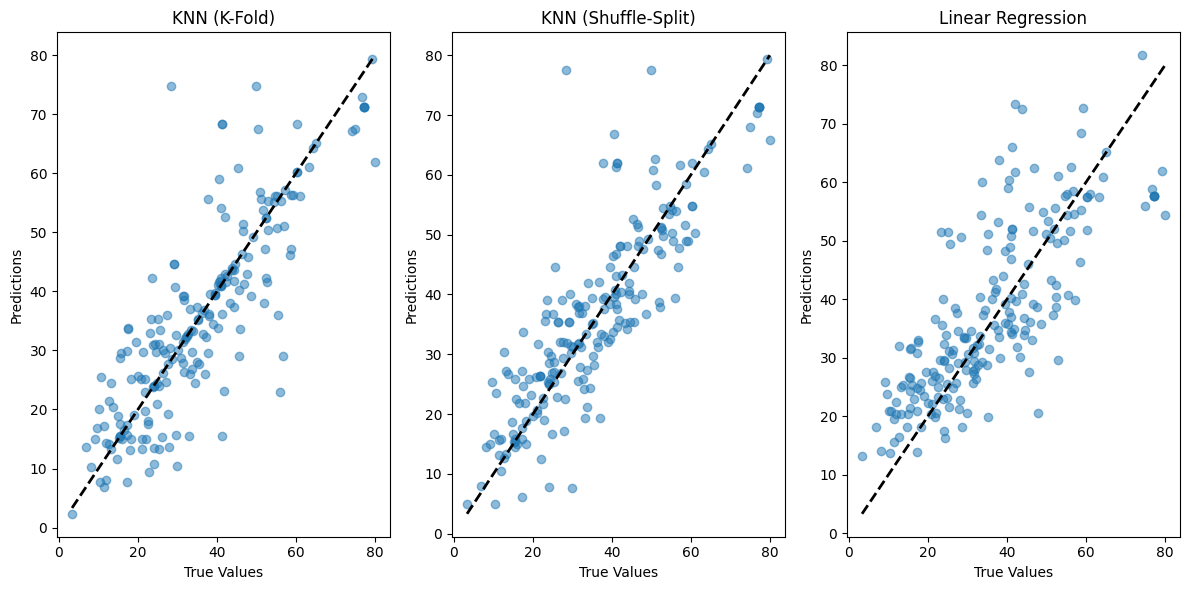

In [70]:
## GENERATED BY CHAT-GPT ##
# Predictions from the models
knn_pred = gs.predict(test_X)
knn2_pred = gs2.predict(test_X)
linear_pred = linear_model.predict(test_X)

# Plotting
plt.figure(figsize=(12, 6))

# KNN with best params from K-Fold
plt.subplot(1, 3, 1)
plt.scatter(test_y, knn_pred, alpha=0.5)
plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], "k--", lw=2)
plt.title("KNN (K-Fold)")
plt.xlabel("True Values")
plt.ylabel("Predictions")

# KNN with best params from Shuffle-Split
plt.subplot(1, 3, 2)
plt.scatter(test_y, knn2_pred, alpha=0.5)
plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], "k--", lw=2)
plt.title("KNN (Shuffle-Split)")
plt.xlabel("True Values")
plt.ylabel("Predictions")

# Linear Regression
plt.subplot(1, 3, 3)
plt.scatter(test_y, linear_pred, alpha=0.5)
plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], "k--", lw=2)
plt.title("Linear Regression")
plt.xlabel("True Values")
plt.ylabel("Predictions")

plt.tight_layout()
plt.show()